## Basic Qiskit Syntax

### Installation

Qiskit is a package in Python for doing everything you'll ever need with quantum computing.

If you don't have it already, you need to install it. Once it is installed, you need to import it.

There are generally two steps to installing Qiskit. The first one is to install Anaconda, a python package that comes with almost all dependencies that you will ever need. Once you've done this, Qiskit can then be installed by running the command 
```
pip install qiskit
```
in your terminal. For detailed installation instructions, refer to [the documentation page here](https://qiskit.org/documentation/install.html).

**Note: The rest of this section is intended for people who already know the fundamental concepts of quantum computing.** It can be used by readers who wish to skip straight to the later chapters in which those concepts are put to use. All other readers should read the [Introduction to Python and Jupyter notebooks](../ch-prerequisites/python-and-jupyter-notebooks.html), and then move on directly to the start of [Chapter 1](../ch-states/introduction.html).

### Quantum circuits

The object at the heart of Qiskit is the quantum circuit. Here's how we create one, which we will call `qc`

In [1]:
from qiskit import QuantumCircuit
qc = QuantumCircuit()

This circuit is currently completely empty, with no qubits and no outputs.

### Quantum registers

To make the circuit less trivial, we need to define a register of qubits. This is done using a `QuantumRegister` object. For example, let's define a register consisting of two qubits and call it `qr`.

In [2]:
from qiskit import QuantumRegister
qr = QuantumRegister(2,'a')

Giving it a label like `'a'` is optional.

Now we can add it to the circuit using the `add_register` method, and see that it has been added by checking the `qregs` variable of the circuit object. This guide uses [Jupyter Notebooks](https://jupyter.org/). In Jupyter Notebooks, the output of the last line of a cell is displayed below the cell:

In [3]:
qc.add_register( qr )

qc.qregs

[QuantumRegister(2, 'a')]

Now our circuit has some qubits, we can use another attribute of the circuit to see what it looks like: `draw()` .

In [4]:
qc.draw()

a_0: 
     
a_1:

Our qubits are ready to begin their journey, but are currently just sitting there in state $\left|0\right\rangle$.

#### Applying Gates

To make something happen, we need to add gates. For example, let's try out `h()`.

In [5]:
qc.h()

TypeError: h() missing 1 required positional argument: 'qubit'

Here we got an error, because we didn't tell the operation which qubit it should act on. The two qubits in our register `qr` can be individually addressed as `qr[0]` and `qr[1]`.

In [6]:
qc.h(qr[0])

Ignore the output in the above. When the last line of a cell has no `=`, Jupyter notebooks like to print out what is there. In this case, it's telling us that there is a Hadamard as defined by Qiskit. To suppress this output, we could use a `;`.

We can also add a controlled-NOT using `cx`. This requires two arguments: control qubit, and then target qubit.

In [7]:
qc.cx(qr[0], qr[1])

Now our circuit has more to show

In [8]:
qc.draw()

┌───┐     
a_0: ┤ H ├──■──
     └───┘┌─┴─┐
a_1: ─────┤ X ├
          └───┘

### Aer simulator

We are now at the stage that we can actually look at an output from the circuit. Specifically, we will use the 'aer simulator' to see what is happening to the state vector of the two qubits.

To get this simulator ready to go, we use the following line.

In [9]:
from qiskit import Aer
sv_sim = Aer.get_backend('aer_simulator')

In Qiskit, we use *backend* to refer to the things on which quantum programs actually run (simulators or real quantum devices). To set up a job for a backend, we need to set up the corresponding backend object.

The simulator we want is defined in the part of qiskit known as `Aer`. By giving the name of the simulator we want to the `get_backend()` method of Aer, we get the backend object we need. In this case, the name is `'aer_simulator'`.

A list of all possible simulators in Aer can be found using

In [10]:
for backend in Aer.backends():
    print(backend)

aer_simulator
aer_simulator_statevector
aer_simulator_density_matrix
aer_simulator_stabilizer
aer_simulator_matrix_product_state
aer_simulator_extended_stabilizer
aer_simulator_unitary
aer_simulator_superop
qasm_simulator
statevector_simulator
unitary_simulator
pulse_simulator


All of these simulators are 'local', meaning that they run on the machine on which Qiskit is installed. Using them on your own machine can be done without signing up to the IBMQ user agreement.

To run this simulation, we need to assemble the circuit into a `Qobj` which contains the circuit, as well as other information about how to run the experiment (for example how many times we should run the circuit), but we will ignore these other options here.

We then use the `.run()` method of the backend we want to use (in this case a simulator) to run the experiment. This is where the quantum computations happen!

In [11]:
from qiskit import assemble
qc.save_statevector()
qobj = assemble(qc)
job = sv_sim.run(qobj)

This creates an object that handles the job, which here has been called `job`. All we need from this is to extract the result. Specifically, we want the state vector.

In [12]:
ket = job.result().get_statevector()
for amplitude in ket:
    print(amplitude)

(0.7071067811865476+0j)
0j
0j
(0.7071067811865475+0j)


/Users/jonathanf/PycharmProjects/qc/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  


This is the vector for a Bell state $\left( \left|00\right\rangle + \left|11\right\rangle \right)/\sqrt{2}$, which is what we'd expect given the circuit.

While we have a nicely defined state vector, we can show another feature of Qiskit: it is possible to initialize a circuit with an arbitrary pure state.

In [13]:
new_qc = QuantumCircuit(qr)

new_qc.initialize(ket, qr)

### Classical registers and the Aer simulator

In the above simulation, we got out a statevector. That's not what we'd get from a real quantum computer. For that we need measurement. And to handle measurement we need to define where the results will go. This is done with a `ClassicalRegister`. Let's define a two bit classical register, in order to measure both of our two qubits.

In [14]:
from qiskit import ClassicalRegister
cr = ClassicalRegister(2,'creg')

qc.add_register(cr)

Now we can use the `measure` method of the quantum circuit. This requires two arguments: the qubit being measured, and the bit where the result is written.

Let's measure both qubits, and write their results in different bits.

In [15]:
qc.measure(qr[0],cr[0])
qc.measure(qr[1],cr[1])

qc.draw()

┌───┐      ░ ┌─┐   
   a_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   a_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
creg: 2/══════════════╩══╩═
                      0  1

Now we can run this on a local simulator whose effect is to emulate a real quantum device. For this we need to add another input to the `assemble` function, `shots`, which determines how many times we run the circuit to take statistics. If you don't provide any `shots` value, you get the default of 1024.

In [28]:
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(qc, shots=8192)
job = aer_sim.run(qobj)

hist = job.result().get_counts()
print(hist)

{'1': 4109, '0': 4083}


We can even get Qiskit to plot it as a histogram.

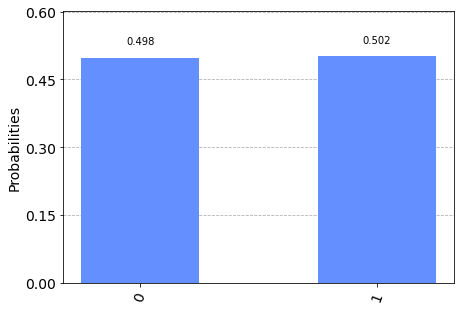

In [29]:
from qiskit.visualization import plot_histogram

plot_histogram(hist)

For compatible backends we can also ask for and get the ordered list of results.

In [18]:
qobj = assemble(qc, shots=10)
job = aer_sim.run(qobj, memory=True)
samples = job.result().get_memory()
print(samples)

['00', '11', '00', '11', '11', '11', '11', '00', '11', '11']


Note that the bits are labelled from right to left. So `cr[0]` is the one to the furthest right, and so on. As an example of this, here's an 8 qubit circuit with a Pauli $X$ on only the qubit numbered `7`, which has its output stored to the bit numbered `7`.

In [19]:
qubit = QuantumRegister(8)
bit = ClassicalRegister(8)
qc_2 = QuantumCircuit(qubit,bit)

qc_2.x(qubit[7])
qc_2.measure(qubit,bit) # this is a way to do all the qc.measure(qr8[j],cr8[j]) at once

qobj = assemble(qc_2, shots=8192)
aer_sim.run(qobj).result().get_counts()

{'10000000': 8192}

The `1` appears at the left.

This numbering reflects the role of the bits when they represent an integer.



$$ b_{n-1} ~ b_{n-2} ~ \ldots ~ b_1 ~ b_0 = \sum_j ~ b_j ~ 2^j $$



So the string we get in our result is the binary for $2^7$ because it has a `1` for the bit numbered `7`.

### Simplified notation

Multiple quantum and classical registers can be added to a circuit. However, if we need no more than one of each, we can use a simplified notation.

For example, consider the following.

In [20]:
qc = QuantumCircuit(3)

The single argument to `QuantumCircuit` is interpreted as the number of qubits we want. So this circuit is one that has a single quantum register consisting of three qubits, and no classical register.

When adding gates, we can then refer to the three qubits simply by their index: 0, 1 or 2. For example, here's a Hadamard on qubit 1.

In [21]:
qc.h(1)

qc.draw()

q_0: ─────
     ┌───┐
q_1: ┤ H ├
     └───┘
q_2: ─────

To define a circuit with both quantum and classical registers, we can supply two arguments to `QuantumCircuit`. The first will be interpreted as the number of qubits, and the second will be the number of bits. For example, here's a two qubit circuit for which we'll take a single bit of output.

In [22]:
qc = QuantumCircuit(2,1)

To see this in action, here is a simple circuit. Note that, when making a measurement, we also refer to the bits in the classical register by index.

In [23]:
qc.h(0)
qc.cx(0,1)
qc.measure(1,0)

qc.draw()

┌───┐        
q_0: ┤ H ├──■─────
     └───┘┌─┴─┐┌─┐
q_1: ─────┤ X ├┤M├
          └───┘└╥┘
c: 1/═══════════╩═
                0

### Creating custom gates

As we've seen, it is possible to combine different circuits to make bigger ones. We can also use a more sophisticated version of this to make custom gates. For example, here is a circuit that implements a `cx` between qubits 0 and 2, using qubit 1 to mediate the process.

In [24]:
sub_circuit = QuantumCircuit(3, name='toggle_cx')
sub_circuit.cx(0,1)
sub_circuit.cx(1,2)
sub_circuit.cx(0,1)
sub_circuit.cx(1,2)

sub_circuit.draw()

q_0: ──■─────────■───────
     ┌─┴─┐     ┌─┴─┐     
q_1: ┤ X ├──■──┤ X ├──■──
     └───┘┌─┴─┐└───┘┌─┴─┐
q_2: ─────┤ X ├─────┤ X ├
          └───┘     └───┘

We can now turn this into a gate

In [25]:
toggle_cx = sub_circuit.to_instruction()

and then insert it into other circuits using any set of qubits we choose

In [26]:
qr = QuantumRegister(4)
new_qc = QuantumCircuit(qr)

new_qc.append(toggle_cx, [qr[1],qr[2],qr[3]])

new_qc.draw()

q1_0: ──────────────
      ┌────────────┐
q1_1: ┤0           ├
      │            │
q1_2: ┤1 toggle_cx ├
      │            │
q1_3: ┤2           ├
      └────────────┘

### Accessing on real quantum hardware

Backend objects can also be set up using the `IBMQ` package. The use of these requires us to [sign with an IBMQ account](https://qiskit.org/documentation/install.html#access-ibm-q-systems). Assuming the credentials are already loaded onto your computer, you sign in with

In [27]:
from qiskit import IBMQ
IBMQ.load_account()

IBMQAccountCredentialsNotFound: 'No IBM Quantum Experience credentials found.'

Now let's see what additional backends we have available.

In [ ]:
provider = IBMQ.get_provider(hub='ibm-q')
for backend in provider.backends():
    print(backend)

Here there is one simulator, but the rest are prototype quantum devices.

We can see what they are up to with the `status()` method.

In [ ]:
for backend in provider.backends():
    print(backend.status().to_dict())

Let's get the backend object for the largest public device.

In [ ]:
real_device = provider.get_backend('ibmq_16_melbourne')

We can use this to run a job on the device in exactly the same way as for the emulator.

We can also extract some of its properties.

In [ ]:
properties = real_device.properties()
coupling_map = real_device.configuration().coupling_map

From this we can construct a noise model to mimic the noise on the device (we will discuss noise models further later in the textbook).

In [ ]:
from qiskit.test.mock import FakeAthens
athens = FakeAthens()

And then run the job on the emulator, with it reproducing all these features of the real device. Here's an example with a circuit that should output `'10'` in the noiseless case.

In [ ]:
qc = QuantumCircuit(5,5)
qc.x(0)
for q in range(4):
    qc.cx(0,q+1)
qc.measure_all()
qc.draw()

In [ ]:
from qiskit.visualization import plot_gate_map
plot_gate_map(athens)

In [ ]:
from qiskit import transpile
t_qc = transpile(qc, athens)
t_qc.draw()

Now the very basics have been covered, let's learn more about what qubits and quantum circuits are all about.

In [ ]:
qobj = assemble(t_qc)
counts = athens.run(qobj).result().get_counts()
plot_histogram(counts)

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table